<a href="https://colab.research.google.com/github/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/06_efficientnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EfficientNet


---


2019年に画像分類タスクでSoTAを達成したEfficientNetについて説明します．

## 概要
EfficientNetは，MnasNetにより得たネットワーク構造を拡張して精度を重視するネットワークに拡張しています．EfficientNetでは，畳み込みニューラルネットワークにおけるネットワークの深さや広さ，解像度等がモデルの性能にどう影響を及ぼすかに着眼しています．
ネットワークの深さ，広さ，解像度をバランスよくスケーリング可能な複合係数（Compound Coefficient）を導入しています．この時，各層のフィルタ数や層数，入力画像サイズの関係を定式化し，１つのパラメータでこれらの値を決定します．これにより，非常に簡単に新たな高精度なネットワーク構造を獲得できるようになりました．EfficientNetは，高精度度なだけでなく，様々なタスクのベースネットワークに活用され，転移学習に有用なネットワーク構造となっています．



<img src="https://drive.google.com/uc?export=view&id=1sUuvFaJ-iqEQOMqUIyTkS-Ycw7QP2TSd" width = 100%>

<img src="https://drive.google.com/uc?export=view&id=1jXTpHVUgc5swKxwBaC0RYwjDsfHuPVSg" width = 60%>



## ファインチューニングと転移学習

### Google Colaboratoryの設定確認・変更
本チュートリアルではPyTorchを利用してニューラルネットワークの実装を確認，学習および評価を行います．
**GPUを用いて処理を行うために，上部のメニューバーの「ランタイム」→「ランタイムのタイプを変更」からハードウェアアクセラレータをGPUにしてください．**

###ファインチューニング
必要なパッケージをインポートします．

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
from time import time
import os 
import numpy as np

from torchsummary import summary

GPUが利用できるか確認します．GPUが利用できる場合はdeviceに"cuda"を代入，利用できない場合はdeviceに"cpu"を代入します．



In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
print('device:{}'.format(device))

device:cuda


In [ ]:
!nvidia-smi

Thu Sep 10 20:03:27 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    12W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

データ拡張の設定を行います．ここでは，ランダムリサイズクロップとランダムクリップをします．また，画像の正規化(明るさの正規化)も行います．
データセットおよびデータ拡張をデータローダに与えます．ミニバッチサイズは１２８とします．
CIFAR10のデータセットはPyTorch公式よりダウンロードして使うことができます．torchvision.datasets.CIFAR10を指定することでデータセットを自動でダウンロードします．
クラス名はディレクトリ名から作成して学習データの場合はtrain_data.classesに含まれています．

In [ ]:
train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
test_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

minibatch = 128
train_data = torchvision.datasets.CIFAR10(root="./", train=True, transform=transforms.ToTensor(), download=True)
val_data = torchvision.datasets.CIFAR10(root="./", train=False, transform=transforms.ToTensor(), download=True)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=minibatch,shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=80,shuffle=True, num_workers=4)

class_names = train_data.classes
print(class_names)

Files already downloaded and verified
Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


学習済みモデルにはResNet18を利用します．pretrained = Trueにすると，ImageNetで学習したモデルを利用できます．ここで，ImageNetは1000クラスのデータセットです．すなわち，ImageNetで学習したResNet18の出力層のユニット数は1000になっています．ファインチューニングに利用するデータセットは１０クラスなので，出力層のユニット数を変更します．

### ネットワークの定義
EfficientNetを学習済みモデルとして利用します．EfficientNetをpipでインストールします．
インストールされたEfficientNetにはImageNetを学習したモデルを利用するオプション(from_pretrained(ネットワーク構造,クラス数))があります．これを利用して学習済みモデルを読み込みます．
EfficientNetはB0からB7までネットワーク構造が違うモデルがあります．from_pretraindedでEfficientNetのネットワーク構造を選択できます．ネットワーク構造をここではB1を利用します．学習済みモデルを読み込む際，転移学習後のクラス数を指定することができます．

In [ ]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

model = EfficientNet.from_pretrained('efficientnet-b0', num_classes = 10) 
print("======== Fine-funing netowrk architecutre ========\n")
print(model)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Loaded pretrained weights for efficientnet-b0
======== Fine-funing netowrk architecutre ========

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding

ネットワークの構造とモデルサイズを確認します．

In [ ]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1            [-1, 3, 34, 34]               0
Conv2dStaticSamePadding-2           [-1, 32, 16, 16]             864
       BatchNorm2d-3           [-1, 32, 16, 16]              64
MemoryEfficientSwish-4           [-1, 32, 16, 16]               0
         ZeroPad2d-5           [-1, 32, 18, 18]               0
Conv2dStaticSamePadding-6           [-1, 32, 16, 16]             288
       BatchNorm2d-7           [-1, 32, 16, 16]              64
MemoryEfficientSwish-8           [-1, 32, 16, 16]               0
          Identity-9             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-10              [-1, 8, 1, 1]             264
MemoryEfficientSwish-11              [-1, 8, 1, 1]               0
         Identity-12              [-1, 8, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 32, 1, 1]             288
         I

学習を行います．エポック数は２５回とします．

In [ ]:
# エポック数の設定
epoch_num = 25
n_iter = len(train_data) / minibatch

best_acc = 0.
start = time()
for epoch in range(1, epoch_num+1):
    model.train() 
    sum_loss = 0.0
    count = 0
    optimizer.step()
    scheduler.step()

    for image, label in train_loader:
        image = image.cuda()
        label = label.cuda()
            
        y = model(image)
        #tensor(max, max_indices)なのでpredは0,1のラベル
        _, preds = torch.max(y, 1)
        loss = criterion(y, label)
                
        model.zero_grad()
        loss.backward()
        optimizer.step()
        
        sum_loss += loss.item()* image.size(0)      
        count += torch.sum(preds == label.data)

    train_loss = sum_loss / len(train_data)
    train_acc = float(count) / len(train_data)
    print("epoch: {}, mean loss: {:.4f}, train accuracy: {:.4f}, elapsed_time :{:.4f}".format(epoch,
                                                                                 train_loss,
                                                                                 train_acc,
                                                                                 time() - start))


    # ネットワークを評価モードへ変更
    model.eval()

    # 評価の実行
    count = 0
    with torch.no_grad():
        for image, label in val_loader:
            image = image.cuda()
            label = label.cuda()
            
            y = model(image)

            #tensor(max, max_indices)なのでpredは0,1のラベル
            _, preds = torch.max(y, 1)
            count += torch.sum(preds == label.data)

        
    val_acc = count.item() / len(val_data)
    if best_acc < val_acc:
      best_acc = val_acc
    print("val accuracy: {:.4f}".format(val_acc))

print("best accuracy: {:.4f}".format(best_acc))


epoch: 1, mean loss: 1.9785, train accuracy: 0.2884, elapsed_time :28.3085
val accuracy: 0.4114
epoch: 2, mean loss: 1.5170, train accuracy: 0.4695, elapsed_time :59.4889
val accuracy: 0.5292
epoch: 3, mean loss: 1.2577, train accuracy: 0.5562, elapsed_time :90.6337
val accuracy: 0.5934
epoch: 4, mean loss: 1.1027, train accuracy: 0.6124, elapsed_time :121.7998
val accuracy: 0.6341
epoch: 5, mean loss: 0.9994, train accuracy: 0.6491, elapsed_time :152.7942
val accuracy: 0.6562
epoch: 6, mean loss: 0.9203, train accuracy: 0.6747, elapsed_time :183.6148
val accuracy: 0.6758
epoch: 7, mean loss: 0.8622, train accuracy: 0.6969, elapsed_time :214.4651
val accuracy: 0.6817
epoch: 8, mean loss: 0.8556, train accuracy: 0.7003, elapsed_time :245.2916
val accuracy: 0.6852
epoch: 9, mean loss: 0.8533, train accuracy: 0.6994, elapsed_time :276.1142
val accuracy: 0.6870
epoch: 10, mean loss: 0.8431, train accuracy: 0.7028, elapsed_time :306.8685
val accuracy: 0.6889
epoch: 11, mean loss: 0.8382, tr

識別結果を確認します

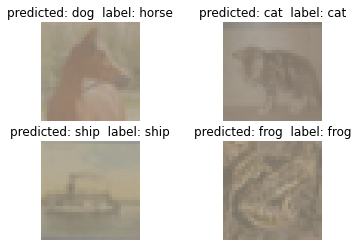

In [ ]:
def tensor_to_numpy(inp):
  "imshow for Tensor"
  inp = inp.numpy().transpose((1,2,0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  return inp

model.eval()
num_images = 4
count = 0
fig = plt.figure()

with torch.no_grad():
    for i, (image, label) in enumerate(val_loader):
        image = image.cuda()
        label = label.cuda()

        y = model(image)
        _, preds = torch.max(y, 1)

        for j in range(image.size()[0]):
            count += 1
            if count - 1 >= num_images:
                break
            ax = fig.add_subplot(num_images//2, 2, count)
            ax.axis('off')
            ax.set_title('predicted: {}  label: {}'
                         .format(class_names[preds[j]], class_names[label[j]]))
            ax.imshow(tensor_to_numpy(image.cpu().data[j]))


In [ ]:
!pip install pytorch-gradcam

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


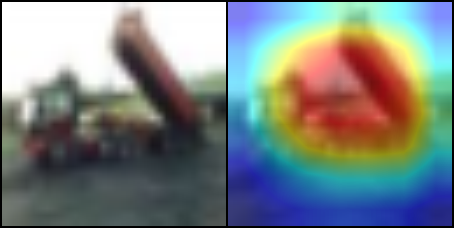

In [ ]:
from gradcam.utils import visualize_cam
from gradcam import GradCAM
from torchvision.utils import make_grid
from PIL import Image

# Grad-CAM
target_layer = model._conv_head # 最後の畳み込み層
gradcam = GradCAM(model, target_layer)

img, label = train_data[2]
torch_img = img.cuda()
to_pil = transforms.ToPILImage(mode='RGB')
pil_img = to_pil(img.squeeze())
torch_img = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])(pil_img).to(device)
normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]
mask, _ = gradcam(normed_torch_img)
heatmap, result = visualize_cam(mask, torch_img)

grid_image = make_grid([torch_img.cpu(), result], nrow=5)

transforms.ToPILImage()(grid_image)

###転移学習
ネットワークの変更した層のみを学習させて転移学習します．
その場合，各層に勾配を逆伝播しないよう，requires_grad を Falseにします．

In [ ]:
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes = 10) 
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, 10)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)  


# エポック数の設定
epoch_num = 25
n_iter = len(train_data) / minibatch

best_acc = 0.
start = time()
for epoch in range(1, epoch_num+1):
    model.train() 
    sum_loss = 0.0
    count = 0
    optimizer.step()
    scheduler.step()

    for image, label in train_loader:
        image = image.cuda()
        label = label.cuda()
            
        y = model(image)
        #tensor(max, max_indices)なのでpredは0,1のラベル
        _, preds = torch.max(y, 1)
        loss = criterion(y, label)
                
        model.zero_grad()
        loss.backward()
        optimizer.step()
        
        sum_loss += loss.item()* image.size(0)      
        count += torch.sum(preds == label.data)

    train_loss = sum_loss / len(train_data)
    train_acc = float(count) / len(train_data)
    print("epoch: {}, mean loss: {:.4f}, train accuracy: {:.4f}, elapsed_time :{:.4f}".format(epoch,
                                                                                 train_loss,
                                                                                 train_acc,
                                                                                 time() - start))


    # ネットワークを評価モードへ変更
    model.eval()

    # 評価の実行
    count = 0
    with torch.no_grad():
        for image, label in val_loader:
            image = image.cuda()
            label = label.cuda()
            
            y = model(image)

            #tensor(max, max_indices)なのでpredは0,1のラベル
            _, preds = torch.max(y, 1)
            count += torch.sum(preds == label.data)

        
    val_acc = count.item() / len(val_data)
    if best_acc < val_acc:
      best_acc = val_acc
    print("val accuracy: {:.4f}".format(val_acc))

print("best accuracy: {:.4f}".format(best_acc))

Loaded pretrained weights for efficientnet-b0
epoch: 1, mean loss: 2.0983, train accuracy: 0.2396, elapsed_time :12.2163
val accuracy: 0.3171
epoch: 2, mean loss: 1.9391, train accuracy: 0.3115, elapsed_time :27.3617
val accuracy: 0.3406
epoch: 3, mean loss: 1.8975, train accuracy: 0.3297, elapsed_time :42.6304
val accuracy: 0.3553
epoch: 4, mean loss: 1.8790, train accuracy: 0.3371, elapsed_time :57.8024
val accuracy: 0.3620
epoch: 5, mean loss: 1.8688, train accuracy: 0.3413, elapsed_time :72.8116
val accuracy: 0.3636
epoch: 6, mean loss: 1.8575, train accuracy: 0.3430, elapsed_time :87.8776
val accuracy: 0.3686
epoch: 7, mean loss: 1.8456, train accuracy: 0.3498, elapsed_time :102.9792
val accuracy: 0.3676
epoch: 8, mean loss: 1.8500, train accuracy: 0.3489, elapsed_time :118.0488
val accuracy: 0.3684
epoch: 9, mean loss: 1.8430, train accuracy: 0.3495, elapsed_time :133.1178
val accuracy: 0.3689
epoch: 10, mean loss: 1.8408, train accuracy: 0.3538, elapsed_time :148.1297
val accura

## 課題
1. 学習率やエポック数を変更して実験を行いましょう．(それぞれのネットワークモデルの性能の変化を調査する)

In [ ]:
#ここにコードを書く

2. EfficientNetのモデルサイズを変更して実験を行いましょう．(B0からB1等)

In [ ]:
#ここにコードを書く

## 参考文献
 - [1] Mingxing Tan and Quoc V. Le, "EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks". In 2019 International Conference on Machine Learning, pp. 6105-6114, 2019.
